# README

The goal of this project is to develop and train a long-short term memory neural network to detect toxic internet comments.

The dataset used in this task was taken from the Toxic Comment Classification Challenge by Jigsaw.

To achieve the goal, the following steps were taken:
1. General preprocessing:

    a. Generalizing the data for binary classification task
    
    b. Data visualization
    
2. Preprocessing for LSTM:

    a. Removing stop words

    b. Lemmatization

    c. Tokenization

    d. Vocabulary creation

3. Building an LSTM model with Pytorch

The project is still in progress, and the full results are yet to be seen.

Warning: Due to working with explicit data, the project contains elements that some may find offensive and obscene.

# 00 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import spacy

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.transformers import AlbertModel, AlbertTokenizer

# 01 General preprocessing

In [3]:
data = pd.read_csv('raw_data/raw_data.csv')
data.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
3146,087ca78aba0dfaeb,"Salaam Hakim, is it possible you can lend be t...",0,0,0,0,0,0
153952,a5c48b1675cb24aa,Yep - moving the article and then turning the ...,0,0,0,0,0,0
108687,451b113954d0cbe1,"Well, if you will, I will. I can guarantee yo...",0,0,0,0,0,0


In [4]:
# Generalization for binary classification task

data['label'] = (data.iloc[:, :-1] == 1).any(axis=1).astype(int)

data.drop(columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat',
                   'insult', 'identity_hate'], inplace=True)

data.sample(5)

,comment_text,label
12707,"""\n\n External links \n\nI know this topic is ...",0
139295,"""\n\n Thankyou! \n\nThank you for helping me b...",0
80069,"""\n\n Wow. We actually have a test that taket ...",0
64845,Thank you for the information. I edited the ar...,0
48262,I'm not so sure these jobs attract that many s...,0


In [5]:
data.shape

(159571, 2)

In [6]:
data[data['label'] == 1].sample(3)['comment_text']

30832    YIFF YIFF \n\nU KNOW U LUV IT LOL, ALL OF THE ...
22852    User:NHRHS2010 is a homo like mitt romney is. ...
5204     Sorry,but the guy is a pratt. He has attacked ...
Name: comment_text, dtype: object

In [7]:
# Checking for dulpicates

data['comment_text'].duplicated().sum()

0

In [8]:
data['comment_text'].dtype

dtype('O')

C:\Users\rados\AppData\Local\Temp\ipykernel_17700\2459196326.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


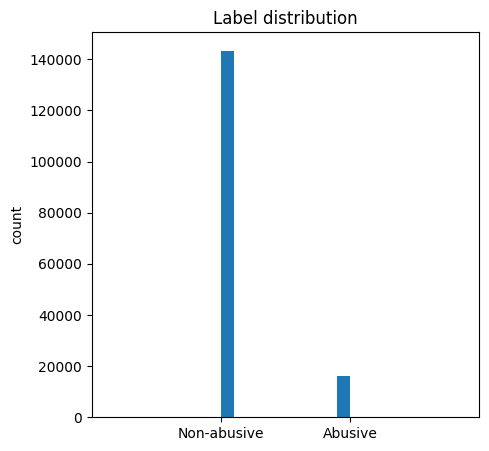

In [9]:
# Distribution of labels

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(data['label'])
ax.set_ylabel('count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-abusive', 'Abusive'])
ax.set_xlim([-1, 2])
ax.set_title('Label distribution')
fig.show()

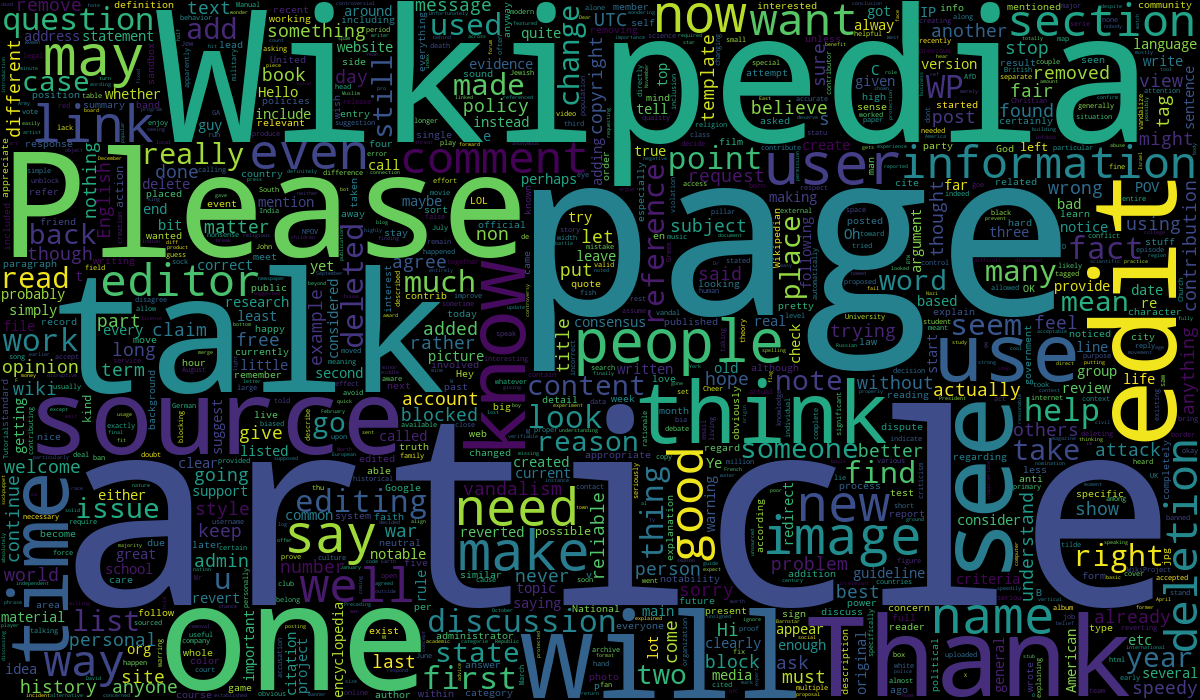

In [10]:
# Word Clouds

text_nonabusive = ' '.join(data[data['label']==0]['comment_text'])

wc_nonabusive = WordCloud(max_words=1000, width=1200,
                   height=700, collocations=False).generate(text_nonabusive)
wc_nonabusive.to_image()

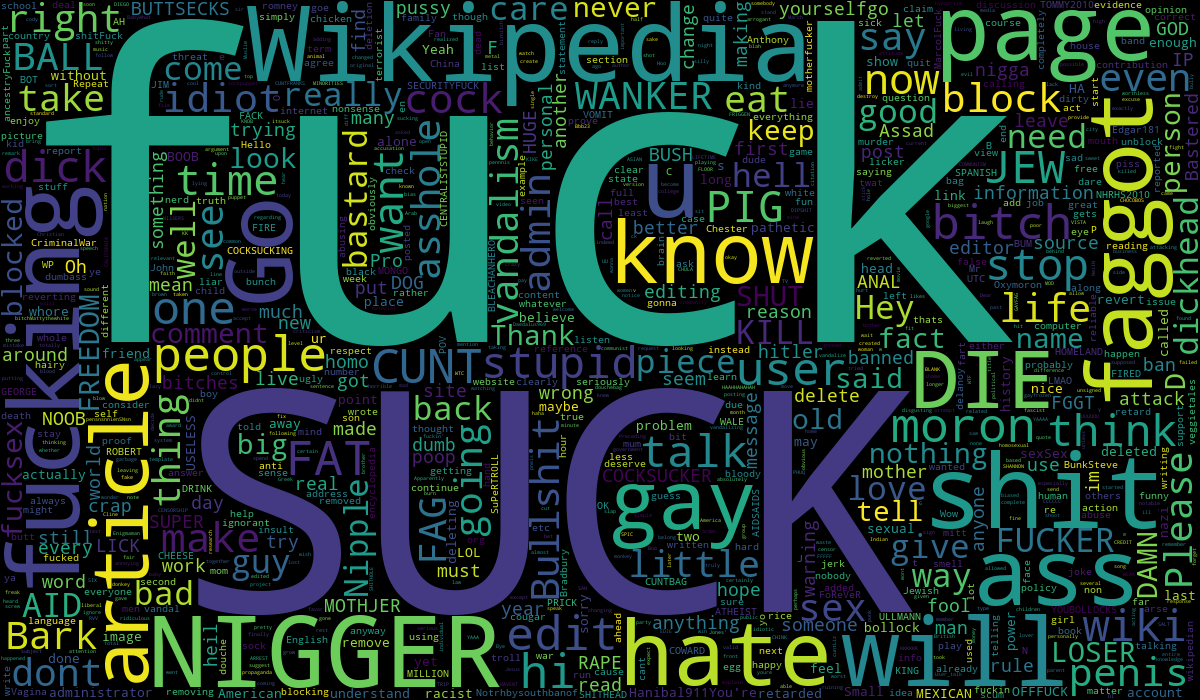

In [11]:
text_abusive = ' '.join(data[data['label']==1]['comment_text'])

wc_abusive = WordCloud(max_words=1000, width=1200,
                   height=700, collocations=False).generate(text_abusive)
wc_abusive.to_image()

# 02 LSTM

In [12]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])

In [13]:
# Removing stopwords

def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['comment_text'] = data['comment_text'].apply(remove_stopwords)

In [14]:
# Lemmatizing

# def lemmatize(text):
#   return ' '.join([x.lemma_ for x in nlp(text)])

# data['comment_text'] = data['comment_text'].apply(lemmatize)
# data.to_csv('preprocessed_data/lemmatized.csv')

data = pd.read_csv('preprocessed_data/lemmatized.csv', index_col=0)

In [15]:
data.sample(5)

,comment_text,label
141490,"re Hi , think I would let know edit I , impost...",1
3615,perhaps snifte valve ?,0
80744,""" so what ? go ahead ban I , I well thing asso...",1
102763,""" Mr. Z - man reply toolserver migration issue...",0
22340,another FAR hi Malleus - Thank comment recent ...,0


In [16]:
# Splitting data

train_size=0.9
val_size=0.2

X_train, X_test, y_train, y_test = train_test_split(
    data['comment_text'], data['label'], train_size=train_size,
    stratify=data['label'], random_state=12)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(val_size / train_size),
    stratify=y_train, random_state=42)


In [17]:
# Token generator

tokenizer = get_tokenizer('spacy', 'en_core_web_md')

def yield_tokens(iter):
  for text in iter:
    yield tokenizer(str(text).lower())

# Creating vocabulary

MAX_TOKENS = 50000

vocab = build_vocab_from_iterator(
    yield_tokens(X_train),
    specials=['<unk>'],
    max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [18]:
vocab(['I', 'like', 'trains'])

[0, 23, 45557]

In [19]:
# Preparing dataloaders

text_pipeline = lambda x: vocab(tokenizer(str(x)))

def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []

  for _text, _label in batch:
    label_list.append(_label)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  labels = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  texts = pad_sequence(text_list, batch_first=True)
  return texts, labels, lenghts

BATCH_SIZE = 128
train_dataloader = DataLoader(list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(list(zip(X_val, y_val)), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [19]:
for i, X in enumerate(train_dataloader):
    print(X)
    if i == 2:
        break

(tensor([[  51,   51,   51,  ...,    0,    0,    0],
        [ 385,   14,   13,  ...,    0,    0,    0],
        [  14,  525,  153,  ...,    0,    0,    0],
        ...,
        [   3,   72,   40,  ...,    0,    0,    0],
        [   3, 1400,  112,  ...,    0,    0,    0],
        [ 356,    2,    0,  ...,    0,    0,    0]]), tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([ 27,  17,  22,  20,  46,  87,  53,  17,  23, 242,  83,  38,  40,  87,
         17,  17

In [20]:
# Creating an LSTM model

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers):

        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):

        embedded = self.embedding(x)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        last_output = output[torch.arange(output.size(0)), lengths - 1, :]

        fc_output = self.fc(last_output)

        output_probabilities = self.sigmoid(fc_output)

        return output_probabilities

In [21]:
# Initializing LSTM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 100
hidden_size = 50
output_size = 1
num_layers = 2

lstm = LSTM(MAX_TOKENS, embedding_dim, hidden_size, output_size, num_layers)
lstm = lstm.to(device)

device

device(type='cuda')

In [58]:
# Training LSTM

criterion = nn.BCELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    
    for i, (texts, labels, lengths) in enumerate(train_dataloader):

        texts, labels = texts.to(device), labels.to(device)
        lstm.train()

        optimizer.zero_grad()
        outputs = lstm(texts, lengths)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:

            lstm.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for val_inputs, val_labels, val_lengths in val_dataloader:

                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_outputs = lstm(val_inputs, val_lengths)
                    val_loss += criterion(val_outputs.squeeze(), val_labels).item()

                    predicted = (val_outputs > 0.5).float().squeeze()
                    correct += (predicted == val_labels).sum().item()
                    total += val_labels.size(0)

            avg_val_loss = val_loss / len(val_dataloader)
            accuracy = 100 * correct / total

            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Validation Loss: {avg_val_loss:.4f}, Validation Acc: {accuracy:.2f}%')

            

Epoch [1/5], Step [100/873], Validation Loss: 0.2961, Validation Acc: 90.14
Epoch [1/5], Step [200/873], Validation Loss: 0.2478, Validation Acc: 91.32
Epoch [1/5], Step [300/873], Validation Loss: 0.2183, Validation Acc: 92.49
Epoch [1/5], Step [400/873], Validation Loss: 0.2032, Validation Acc: 93.11
Epoch [1/5], Step [500/873], Validation Loss: 0.2022, Validation Acc: 92.84
Epoch [1/5], Step [600/873], Validation Loss: 0.1742, Validation Acc: 93.86
Epoch [1/5], Step [700/873], Validation Loss: 0.1642, Validation Acc: 94.33
Epoch [1/5], Step [800/873], Validation Loss: 0.1655, Validation Acc: 94.41
Epoch [2/5], Step [100/873], Validation Loss: 0.1515, Validation Acc: 94.83
Epoch [2/5], Step [200/873], Validation Loss: 0.1493, Validation Acc: 94.72
Epoch [2/5], Step [300/873], Validation Loss: 0.1471, Validation Acc: 94.94
Epoch [2/5], Step [400/873], Validation Loss: 0.1372, Validation Acc: 95.16
Epoch [2/5], Step [500/873], Validation Loss: 0.1402, Validation Acc: 95.03
Epoch [2/5],

In [59]:
# Saving model params

lstm_path = 'models\lstm_valacc96_valloss012.pth'
torch.save(lstm.state_dict(), lstm_path)

In [22]:
# Loading lstm model

lstm_path = 'models\lstm_valacc96_valloss012.pth'
lstm.load_state_dict(torch.load(lstm_path))

<All keys matched successfully>

In [35]:
# LSTM test eval

lstm.eval()
criterion = nn.BCELoss()
tp = 0
tn = 0
fp = 0
fn = 0
test_loss = 0

with torch.no_grad():

    for (test_inputs, test_labels, test_lenghts) in test_dataloader:

        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_outputs = lstm(test_inputs, test_lenghts).squeeze()
        test_loss += criterion(test_outputs, test_labels).item()

        test_pred = (test_outputs > 0.5).float()
        tp += ((test_pred == 1) & (test_labels == 1)).sum().item()
        tn += ((test_pred == 0) & (test_labels == 0)).sum().item()
        fp += ((test_pred == 1) & (test_labels == 0)).sum().item()
        fn += ((test_pred == 0) & (test_labels == 1)).sum().item()

    total = (tp + tn + fp + fn)
    lstm_conf_matrix = torch.tensor([[tp, fp], [fn, tn]])
    lstm_test_acc = 100 * (tp + tn) / total
    lstm_avg_test_loss = test_loss / len(test_dataloader)

    print(f'Test acc: {lstm_test_acc:.2f}\nAvg test loss: {lstm_avg_test_loss:.4f}\nConfusion matrix: \n{lstm_conf_matrix}')

Test acc: 95.73
Avg test loss: 0.1246
Confusion matrix: 
tensor([[ 1158,   223],
        [  459, 14118]])


In [24]:
# Sentance test

your_sentence = 'The sun is shining, children are playing'

def sentence_preproc(sentence):
   sentence = ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, sentence.split()))
   sentence = ' '.join([x.lemma_ for x in nlp(sentence)])
   tokens = tokenizer(sentence)
   sentence = torch.tensor([vocab(tokens)])
   sentence = sentence.to(device)
   length = torch.tensor([len(tokens)])
   return sentence, length

preproc_sentence, length = sentence_preproc(your_sentence)
prediction = lstm(preproc_sentence, length).item()
result = round(prediction)

print(f'Chance of being abusive: {(100 * prediction):.2f}%')
if result == 1:
   print(f'Your sentence: {your_sentence}\nPrediction: This is an abusive sentence')
else:
   print(f'Your sentence: {your_sentence}\nPrediction: This is a non-abusive sentence')

Chance of being abusive: 1.26%
Your sentence: The sun is shining, children are playing
Prediction: This is a non-abusive sentence


# 03 CNN

In [29]:
# Creating a CNN model

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_size, dropout_prob):
        
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)

        conv_outputs = [nn.functional.relu(conv(embedded)) for conv in self.conv_layers]
        pooled_outputs = [nn.functional.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_outputs]

        cat_output = torch.cat(pooled_outputs, dim=1)

        cat_output = self.dropout(cat_output)

        fc_output = self.fc(cat_output)

        output_probabilities = self.sigmoid(fc_output)

        return output_probabilities

In [30]:
# Initializing CNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 100
num_filters = 128
filter_sizes = [3, 4, 5]
output_size = 1
dropout_prob = 0.5

cnn = CNNModel(MAX_TOKENS, embedding_dim, num_filters, filter_sizes, output_size, dropout_prob)
cnn = cnn.to(device)

In [31]:
# Training CNN

criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    
    for i, (texts, labels, lengths) in enumerate(train_dataloader):

        texts, labels = texts.to(device), labels.to(device)
        cnn.train()

        optimizer.zero_grad()
        outputs = cnn(texts)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:

            cnn.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for val_inputs, val_labels, _ in val_dataloader:

                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_outputs = cnn(val_inputs)
                    val_loss += criterion(val_outputs.squeeze(), val_labels).item()

                    predicted = (val_outputs > 0.5).float().squeeze()
                    correct += (predicted == val_labels).sum().item()
                    total += val_labels.size(0)

            avg_val_loss = val_loss / len(val_dataloader)
            accuracy = 100 * correct / total

            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Validation Loss: {avg_val_loss:.4f}, Validation Acc: {accuracy:.2f}%')
    

Epoch [1/5], Step [100/873], Validation Loss: 0.2362, Validation Acc: 91.48%
Epoch [1/5], Step [200/873], Validation Loss: 0.2098, Validation Acc: 92.47%
Epoch [1/5], Step [300/873], Validation Loss: 0.1933, Validation Acc: 93.23%
Epoch [1/5], Step [400/873], Validation Loss: 0.1737, Validation Acc: 93.69%
Epoch [1/5], Step [500/873], Validation Loss: 0.1657, Validation Acc: 93.89%
Epoch [1/5], Step [600/873], Validation Loss: 0.1594, Validation Acc: 94.24%
Epoch [1/5], Step [700/873], Validation Loss: 0.1506, Validation Acc: 94.46%
Epoch [1/5], Step [800/873], Validation Loss: 0.1478, Validation Acc: 94.64%
Epoch [2/5], Step [100/873], Validation Loss: 0.1407, Validation Acc: 94.87%
Epoch [2/5], Step [200/873], Validation Loss: 0.1403, Validation Acc: 94.85%
Epoch [2/5], Step [300/873], Validation Loss: 0.1362, Validation Acc: 95.05%
Epoch [2/5], Step [400/873], Validation Loss: 0.1386, Validation Acc: 94.93%
Epoch [2/5], Step [500/873], Validation Loss: 0.1315, Validation Acc: 95.18%

In [32]:
# Saving model params

cnn_path = 'models\cnn_vallacc96_valloss012.pth'
torch.save(cnn.state_dict(), cnn_path)

In [33]:
# Loading cnn model

cnn_path = 'models\cnn_vallacc96_valloss012.pth'
cnn.load_state_dict(torch.load(cnn_path))

<All keys matched successfully>

In [36]:
# CNN test eval

cnn.eval()
criterion = nn.BCELoss()
tp = 0
tn = 0
fp = 0
fn = 0
test_loss = 0

with torch.no_grad():

    for (test_inputs, test_labels, _) in test_dataloader:

        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_outputs = cnn(test_inputs).squeeze()
        test_loss += criterion(test_outputs, test_labels).item()

        test_pred = (test_outputs > 0.5).float()
        tp += ((test_pred == 1) & (test_labels == 1)).sum().item()
        tn += ((test_pred == 0) & (test_labels == 0)).sum().item()
        fp += ((test_pred == 1) & (test_labels == 0)).sum().item()
        fn += ((test_pred == 0) & (test_labels == 1)).sum().item()

    total = (tp + tn + fp + fn)
    cnn_conf_matrix = torch.tensor([[tp, fp], [fn, tn]])
    cnn_test_acc = 100 * (tp + tn) / total
    cnn_avg_test_loss = test_loss / len(test_dataloader)

    print(f'Test acc: {cnn_test_acc:.2f}\nAvg test loss: {cnn_avg_test_loss:.4f}\nConfusion matrix: \n{cnn_conf_matrix}')

Test acc: 95.54
Avg test loss: 0.1295
Confusion matrix: 
tensor([[ 1142,   237],
        [  475, 14104]])


# 04 LSTM with GloVe

In [20]:
# Loading GloVe embeddings

def load_glove_embeddings(file_path):
    word_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = vector
    return word_embeddings

glove_file_path = 'models/glove.6B/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)

In [35]:
# Defining LSTM with GloVe

class LSTMWithGloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers, pretrained_embeddings):

        super(LSTMWithGloVe, self).__init__()

        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for idx, word in enumerate(vocab.get_itos()):
            if word in pretrained_embeddings:
                embedding_matrix[idx] = pretrained_embeddings[word]
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        last_output = output[torch.arange(output.size(0)), lengths - 1, :]
        fc_output = self.fc(last_output)
        output_probabilities = self.sigmoid(fc_output)
        return output_probabilities

In [36]:
# Initializing LSTM with GloVe

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 100
hidden_size = 50
output_size = 1
num_layers = 2

gloveLstm = LSTMWithGloVe(MAX_TOKENS, embedding_dim, hidden_size, output_size, num_layers, glove_embeddings)
gloveLstm = gloveLstm.to(device)

device

device(type='cuda')

In [37]:
# Training GloVe LSTM

criterion = nn.BCELoss()
optimizer = optim.Adam(gloveLstm.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    
    for i, (texts, labels, lengths) in enumerate(train_dataloader):

        texts, labels = texts.to(device), labels.to(device)
        gloveLstm.train()

        optimizer.zero_grad()
        outputs = gloveLstm(texts, lengths)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:

            gloveLstm.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for val_inputs, val_labels, val_lengths in val_dataloader:

                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_outputs = gloveLstm(val_inputs, val_lengths)
                    val_loss += criterion(val_outputs.squeeze(), val_labels).item()

                    predicted = (val_outputs > 0.5).float().squeeze()
                    correct += (predicted == val_labels).sum().item()
                    total += val_labels.size(0)

            avg_val_loss = val_loss / len(val_dataloader)
            accuracy = 100 * correct / total

            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Validation Loss: {avg_val_loss:.4f}, Validation Acc: {accuracy:.2f}%')

Epoch [1/5], Step [100/873], Validation Loss: 0.2572, Validation Acc: 90.53%
Epoch [1/5], Step [200/873], Validation Loss: 0.1978, Validation Acc: 92.91%
Epoch [1/5], Step [300/873], Validation Loss: 0.1796, Validation Acc: 93.87%
Epoch [1/5], Step [400/873], Validation Loss: 0.1626, Validation Acc: 94.20%
Epoch [1/5], Step [500/873], Validation Loss: 0.1663, Validation Acc: 94.34%
Epoch [1/5], Step [600/873], Validation Loss: 0.1524, Validation Acc: 94.70%
Epoch [1/5], Step [700/873], Validation Loss: 0.1498, Validation Acc: 94.69%
Epoch [1/5], Step [800/873], Validation Loss: 0.1434, Validation Acc: 94.92%
Epoch [2/5], Step [100/873], Validation Loss: 0.1498, Validation Acc: 94.74%
Epoch [2/5], Step [200/873], Validation Loss: 0.1433, Validation Acc: 94.76%
Epoch [2/5], Step [300/873], Validation Loss: 0.1381, Validation Acc: 95.02%
Epoch [2/5], Step [400/873], Validation Loss: 0.1410, Validation Acc: 94.95%
Epoch [2/5], Step [500/873], Validation Loss: 0.1332, Validation Acc: 95.13%

In [39]:
# Saving model params

gloveLstm_path = 'models\gloveLstm_valacc95_valloss018.pth'
torch.save(gloveLstm.state_dict(), gloveLstm_path)

In [40]:
# Loading GloVe LSTM model

gloveLstm_path = 'models\gloveLstm_valacc95_valloss018.pth'
gloveLstm.load_state_dict(torch.load(gloveLstm_path))

<All keys matched successfully>

In [38]:
# GloVe LSTM test eval

gloveLstm.eval()
criterion = nn.BCELoss()
tp = 0
tn = 0
fp = 0
fn = 0
test_loss = 0

with torch.no_grad():

    for (test_inputs, test_labels, test_lenghts) in test_dataloader:

        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_outputs = gloveLstm(test_inputs, test_lenghts).squeeze()
        test_loss += criterion(test_outputs, test_labels).item()

        test_pred = (test_outputs > 0.5).float()
        tp += ((test_pred == 1) & (test_labels == 1)).sum().item()
        tn += ((test_pred == 0) & (test_labels == 0)).sum().item()
        fp += ((test_pred == 1) & (test_labels == 0)).sum().item()
        fn += ((test_pred == 0) & (test_labels == 1)).sum().item()

    total = (tp + tn + fp + fn)
    gloveLstm_conf_matrix = torch.tensor([[tp, fp], [fn, tn]])
    gloveLstm_test_acc = 100 * (tp + tn) / total
    gloveLstm_avg_test_loss = test_loss / len(test_dataloader)

    print(f'Test acc: {gloveLstm_test_acc:.2f}\nAvg test loss: {gloveLstm_avg_test_loss:.4f}\nConfusion matrix: \n{gloveLstm_conf_matrix}')

Test acc: 94.51
Avg test loss: 0.1863
Confusion matrix: 
tensor([[ 1096,   355],
        [  521, 13986]])


# 05 AlBERT fine-tuning

In [ ]:
# Defining AlBERT model

class ALBERTForFineTuning(nn.Module):
    def __init__(self, pretrained_model_name, hidden_size, output_size, num_layers):
        super(ALBERTForFineTuning, self).__init__()

        # Load pre-trained ALBERT model and tokenizer
        self.albert = AlbertModel.from_pretrained(pretrained_model_name)
        self.tokenizer = AlbertTokenizer.from_pretrained(pretrained_model_name)

        # Replace the embedding layer with ALBERT
        self.embedding_dim = self.albert.config.hidden_size

        self.lstm = nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        # Tokenize input
        input_ids = self.tokenizer(x, return_tensors='pt', padding=True, truncation=True)['input_ids']

        # Get ALBERT embeddings
        albert_output = self.albert(input_ids)[0]

        # LSTM part
        packed_embedded = pack_padded_sequence(albert_output, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        last_output = output[torch.arange(output.size(0)), lengths - 1, :]
        
        # Fully connected layer
        fc_output = self.fc(last_output)

        # Sigmoid activation
        output_probabilities = self.sigmoid(fc_output)

        return output_probabilities